# Texas Hold'em Poker: A Case Study with Probability and Monte Carlo Simulation

Poker is not only a game of skill — it is a game of uncertainty, risk, and probability.

Texas Hold'em is an ideal domain to apply probability concepts, because each game involves hidden information, chance outcomes, and strategic decisions.



## Texas Hold'em case study
Probability is a magnificent tool to understand a repeated process which has certain distribution of outcomes, it is possible to model all sorts of phenomena but it is hard to reach the insight. Games that have "random outcome" naturally are the best field to understand the stochastic view.
The objective of this proyect is to use basic concepts of probability to develop expertise on a card game, and insight in stocastic process, using simulation and basic conditional probability.


## The Basics of Texas Hold'em

****Objective:**** Win chips by forming the best 5-card Poker hand from your two private cards ("hole cards") plus five community cards.

### Poker Hand Rankings (from strongest to weakest):

1. Royal Flush
2. Straight Flush
3. Four of a Kind
4. Full House
5. Flush
6. Straight
7. Three of a Kind
8. Two Pair
9. One Pair
10. High Card

---

### How Probability Helps

- We can simulate **many thousands of games** to estimate how often different hands win.
- This gives us insights into *which hands are strong in different situations*.
- For example, how does the strength of a pair of Aces change if there are 2 players vs 6 players?

In this notebook we will use **Monte Carlo simulation** — run random Poker games many times — to explore these questions.


In [4]:
# Import required libraries
# Import required libraries
import random
import pandas as pd
from collections import Counter


# Setup deck using ascii characters
suits = ['♠', '♥', '♦', '♣']
values = ['2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']
deck = [s + v for v in values for s in suits] # Get the combinations of suits and values

# Hand classification
def classify_hand(cards):
    ranks_order = '23456789TJQKA'
    # Using Counter to get on dictionaries the cardinals of our hand
    suit_counts = Counter(card[0] for card in cards)  # The first input on list (0-input) is for our suits type
    number_counts = Counter(card[1] for card in cards)  # The second is for our number type
    counts = sorted(number_counts.values(), reverse=True) # Get the ordinals of number type
    is_flush = max(suit_counts.values()) >= 5 #Check if exist flush, use meq, thinking on reaching a river ideal scenario

    # Convert number to indixes and compute straight
    idxs = sorted(ranks_order.index(r) for r in number_counts)
    if idxs == [0, 1, 2, 3, 12]: # Special case Ace low
        is_straight = True
    else:
        is_straight = all(idxs[i] + 1 == idxs[i+1] for i in range(len(idxs)-1))

    # Determine hand category
    if is_straight and is_flush:
        return 'Straight Flush'
    if counts[0] == 4:
        return 'Four of a Kind'
    if counts[0] == 3 and counts[1] == 2:
        return 'Full House'
    if is_flush:
        return 'Flush'
    if is_straight:
        return 'Straight'
    if counts[0] == 3:
        return 'Three of a Kind'
    if counts[0] == 2 and counts[1] == 2:
        return 'Two Pair'
    if counts[0] == 2:
        return 'One Pair'
    return 'High Card'

# Monte Carlo simulation
def simulate_hand_probs(n_simulations=100000, n_cards = 5):
    results = Counter()
    for _ in range(n_simulations):
        hand = random.sample(deck, n_cards)
        category = classify_hand(hand)
        results[category] += 1
    df = pd.DataFrame([
        {'Hand': hand, 'Probability': count / n_simulations}
        for hand, count in results.items()
    ])

    df['Odds (ratio)'] = df['Probability'] / (1 - df['Probability'])

    return df.sort_values('Probability', ascending=False)

# Run and display
df_probs = simulate_hand_probs(100000)
print("At the Flop",df_probs)

df_probs = simulate_hand_probs(100000, 6)
print("\nAt the Turn",df_probs)

df_probs = simulate_hand_probs(100000, 7)
print("\nAt the River",df_probs)


At the Flop               Hand  Probability  Odds (ratio)
0        High Card      0.50271      1.010899
2         One Pair      0.41392      0.706252
1         Two Pair      0.04604      0.048262
3  Three of a Kind      0.02067      0.021106
4         Straight      0.01273      0.012894
5            Flush      0.00208      0.002084
6       Full House      0.00147      0.001472
7   Four of a Kind      0.00035      0.000350
8   Straight Flush      0.00003      0.000030

At the Turn               Hand  Probability  Odds (ratio)
1         One Pair      0.47792      0.915415
0        High Card      0.33768      0.509844
4         Two Pair      0.12274      0.139913
2  Three of a Kind      0.03542      0.036721
5            Flush      0.00983      0.009928
3       Full House      0.00810      0.008166
6         Straight      0.00744      0.007496
7   Four of a Kind      0.00080      0.000801
8   Straight Flush      0.00007      0.000070

At the River               Hand  Probability  Odds (ra

These probabilities are calculated using martingale perspective of one player, so is the most basic case are the referencial power of hands, we can classify the hands in general way

**Almost-winners:**
* Straight Flush
* Four of a Kind
* Full House

**Rare**
* Straight
* Flush
* Three of Kind

**Common**
* High card
* Two Pair
* One pair

These clasification is categorical and the powerfulness is not linear, nonetheless exponencial. Tag them is only for a general purposes but useful to start study.



In [5]:
import itertools
# Ranking for categories to order and get a winner
category_ranks = {
    'High Card': 0, 'One Pair': 1, 'Two Pair': 2, 'Three of a Kind': 3,
    'Straight': 4, 'Flush': 5, 'Full House': 6, 'Four of a Kind': 7, 'Straight Flush': 8
}

def best_hand_category(cards):
    """Determine the best hand given some cards"""
    best_rank = -1 #Use an non-positive value to assure we are really reach some hand clasification
    best_cat = None
    for combo in itertools.combinations(cards, 5):
        cat = classify_hand(combo)
        rank = category_ranks[cat]
        if rank > best_rank:
            best_rank = rank
            best_cat = cat
    return best_cat

def simulate_games(n_games=1, players = 6, n_c_community = 3):
    """
    Simulate n_games of Texas Hold'em with 6 players.
    Return a dictionary: Player -> Counter of hand types.
    """
    counts = {f'Player {i+1}': Counter() for i in range(players)}
    for _ in range(n_games):
        d = deck[:]
        random.shuffle(d)
        # Deal hole cards each player
        holes = [[d.pop(), d.pop()] for _ in range(players)]
        # Deal community cards, base function finish at flop change 3 to 4 or 5
        community = [d.pop() for _ in range(n_c_community)]
        # Evaluate each player at the flop
        for i, hole in enumerate(holes):
            cat = best_hand_category(hole + community)
            counts[f'Player {i+1}'][cat] += 1
    return counts

# Run simulation and display the counts
game_summary = simulate_games()
game_summary

{'Player 1': Counter({'One Pair': 1}),
 'Player 2': Counter({'One Pair': 1}),
 'Player 3': Counter({'One Pair': 1}),
 'Player 4': Counter({'One Pair': 1}),
 'Player 5': Counter({'One Pair': 1}),
 'Player 6': Counter({'Three of a Kind': 1})}

In [6]:
# Import required libraries
# Import required libraries
import random
from collections import Counter

def simulate_games_2(n_games=1, players=6):
    """
    Simulate n_games of Texas Hold'em with multiple players,
    evaluating hand categories at Flop (3 community cards),
    Turn (4 community cards), and River (5 community cards).
    Returns a dictionarie of stage -> player counters.
    """
    # Initialize counters for each stage
    counts = {
        'Flop':    {f'Player {i+1}': Counter() for i in range(players)},
        'Turn':    {f'Player {i+1}': Counter() for i in range(players)},
        'River':   {f'Player {i+1}': Counter() for i in range(players)},
    }

    for _ in range(n_games):
        # Shuffle
        deck_copy = deck[:]
        random.shuffle(deck_copy)

        # Deal hole cards to players
        holes = [[deck_copy.pop(), deck_copy.pop()] for _ in range(players)]

        # Deal community cards in instances
        community = []

        # Flop instance
        community.extend([deck_copy.pop() for _ in range(3)])
        for i, hole in enumerate(holes):
            cat = best_hand_category(hole + community)
            counts['Flop'][f'Player {i+1}'][cat] += 1

        # Turn instance
        community.append(deck_copy.pop())
        for i, hole in enumerate(holes):
            cat = best_hand_category(hole + community)
            counts['Turn'][f'Player {i+1}'][cat] += 1

        # River instance
        community.append(deck_copy.pop())
        for i, hole in enumerate(holes):
            cat = best_hand_category(hole + community)
            counts['River'][f'Player {i+1}'][cat] += 1

    return counts

# Example usage:
results = simulate_games_2(players = 10)

for stage, player_counts in results.items():
    print(f"\n== {stage} ==")
    for player, counter in player_counts.items():
        print(f"{player}: {dict(counter)}")



== Flop ==
Player 1: {'High Card': 1}
Player 2: {'High Card': 1}
Player 3: {'One Pair': 1}
Player 4: {'High Card': 1}
Player 5: {'High Card': 1}
Player 6: {'High Card': 1}
Player 7: {'One Pair': 1}
Player 8: {'High Card': 1}
Player 9: {'One Pair': 1}
Player 10: {'High Card': 1}

== Turn ==
Player 1: {'One Pair': 1}
Player 2: {'Straight': 1}
Player 3: {'Two Pair': 1}
Player 4: {'One Pair': 1}
Player 5: {'One Pair': 1}
Player 6: {'One Pair': 1}
Player 7: {'Two Pair': 1}
Player 8: {'One Pair': 1}
Player 9: {'Three of a Kind': 1}
Player 10: {'One Pair': 1}

== River ==
Player 1: {'Flush': 1}
Player 2: {'Straight': 1}
Player 3: {'Two Pair': 1}
Player 4: {'One Pair': 1}
Player 5: {'Flush': 1}
Player 6: {'Straight': 1}
Player 7: {'Straight': 1}
Player 8: {'Straight': 1}
Player 9: {'Straight': 1}
Player 10: {'Flush': 1}


In [7]:
# Function: Aggregate the number of wins for each hand type
# Function: Aggregate the number of wins for each hand type
def aggregate_counts(results):
    """
    Given results as returned by simulate_games_2 (a dict of stage -> {player: Counter}),
    return a dict of stage -> Counter of total hands across all players.
    """
    agg = {}
    for stage, player_counters in results.items():
        # Sum all the individual Counters into one
        total = sum(player_counters.values(), Counter())
        agg[stage] = total
    return agg

# Example usage(using the results on the cell before)
overall = aggregate_counts(results)

for stage, counter in overall.items():
    print(f"\n== {stage} totals across all players ==")
    for hand, count in counter.items():
        print(f"{hand:15s}: {count}")


== Flop totals across all players ==
High Card      : 7
One Pair       : 3

== Turn totals across all players ==
One Pair       : 6
Straight       : 1
Two Pair       : 2
Three of a Kind: 1

== River totals across all players ==
Flush          : 3
Straight       : 5
Two Pair       : 1
One Pair       : 1


In [8]:
# Function: Aggregate the number of wins for each hand type
# Function: Aggregate the number of wins for each hand type
# Generate agregate counting of hands on one game
results = simulate_games_2(players = 6)
overall = aggregate_counts(results)

for stage, counter in overall.items():
    print(f"\n== {stage} totals across all players ==")
    for hand, count in counter.items():
        print(f"{hand:15s}: {count}")


== Flop totals across all players ==
One Pair       : 4
High Card      : 2

== Turn totals across all players ==
One Pair       : 5
High Card      : 1

== River totals across all players ==
Flush          : 1
One Pair       : 4
High Card      : 1


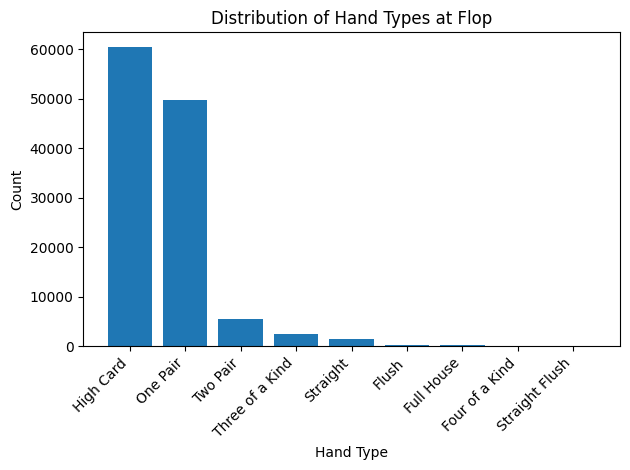

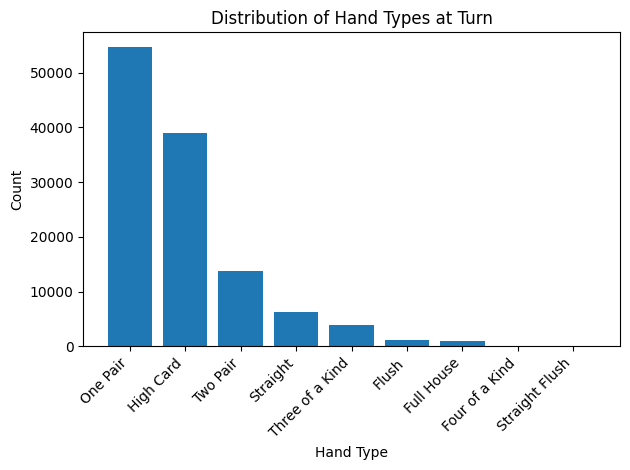

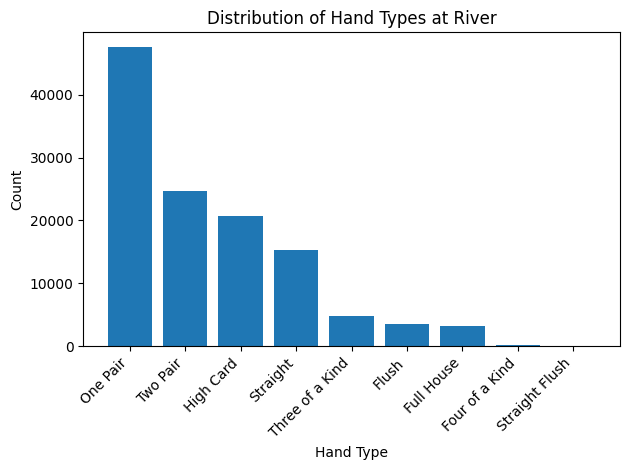

In [9]:
# Function: Aggregate the number of wins for each hand type
# Function: Aggregate the number of wins for each hand type
# graph on 20,000 games and 6 players
import matplotlib.pyplot as plt

results = simulate_games_2(n_games=20000,players = 6)
overall = aggregate_counts(results)

for stage, counter in overall.items():
    # Sort categories by count descending
    categories, counts_sorted = zip(*sorted(counter.items(), key=lambda x: x[1], reverse=True))

    plt.figure()
    plt.bar(categories, counts_sorted)
    plt.title(f'Distribution of Hand Types at {stage}')
    plt.xlabel('Hand Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Looking at graphs, we can understand that the hand at different stages is more valuable or less valuable, so understand the stages and pot proportion is the key, because the pot plays a major role in determining whether you win or lose.

Using Monte Carlo Logic. We select one player and look at its summarized results.

Flop is the most crucial moment because before flop, the players has only two cards, then a los of possibilities, that is no tangible calculate. If we do start with 50 C 5, a big number even with our power computing level. So we analize the cases after the flop. For me is the most important, as a decision tree this is the big stand. We do simulations for different number of players.

In [10]:
# Function: Simulate wins conditional on starting hand
# Function: Simulate wins conditional on starting hand
def simulate_conditional_win(n_games=20000, players=6, focus_player=0):
    totals = Counter()
    wins = Counter()
    for _ in range(n_games):
        deck_copy = deck[:]
        random.shuffle(deck_copy)
        holes = [[deck_copy.pop(), deck_copy.pop()] for _ in range(players)]

        # Flop
        community = [deck_copy.pop() for _ in range(3)]
        flop_cat = best_hand_category(holes[focus_player] + community)
        totals[flop_cat] += 1

        # Turn & River
        community.append(deck_copy.pop())
        community.append(deck_copy.pop())

        # Determine winners, we add a higher card criteria for draw hands, there excepcional
        ranks = [category_ranks[best_hand_category(h + community)] for h in holes]
        max_rank = max(ranks)
        winners = [i for i, r in enumerate(ranks) if r == max_rank]
        if focus_player in winners:
            wins[flop_cat] += 1

    # Build DataFrame
    df = pd.DataFrame([
        {
            f'Flop Category N{players}': cat,
            'Total': totals[cat],
            'Wins': wins.get(cat, 0),
            'Win Probability': wins.get(cat, 0) / totals[cat] if totals[cat] > 0 else 0
        }
        for cat in totals
    ]).sort_values('Win Probability', ascending=False)

    return df

# Run the simulation for Player 1
simulate_conditional_win()

# Run the simulation for Player 1
for i in range(4,11):
  print("\n",simulate_conditional_win(players=i))


   Flop Category N4  Total  Wins  Win Probability
7   Four of a Kind      5     5         1.000000
8   Straight Flush      1     1         1.000000
6            Flush     46    45         0.978261
5       Full House     35    34         0.971429
4         Straight    247   218         0.882591
2  Three of a Kind    406   307         0.756158
1         Two Pair    929   627         0.674919
3         One Pair   8242  4416         0.535792
0        High Card  10089  3039         0.301219

   Flop Category N5  Total  Wins  Win Probability
7   Four of a Kind      5     5         1.000000
4       Full House     20    20         1.000000
6            Flush     30    29         0.966667
5         Straight    242   207         0.855372
3  Three of a Kind    412   310         0.752427
2         Two Pair    892   542         0.607623
1         One Pair   8278  3749         0.452887
0        High Card  10121  2574         0.254323

   Flop Category N6  Total  Wins  Win Probability
7   Four of a 

We can observe that as the number of players increases the efectiveness of some hands decay. Therefore, the strategies become less effective.

Two pair is the perfect example. Playing with three people a hand with two pairs has a positive odds ratio but with nine people the odds are near one half not a power hand.

In [11]:
def simulate_win_by_turn(n_games=20000, players=6, focus_player=0):
    totals = Counter()
    wins = Counter()
    for _ in range(n_games):
        deck_copy = deck[:]
        random.shuffle(deck_copy)
        holes = [[deck_copy.pop(), deck_copy.pop()] for _ in range(players)]

        # Flop + Turn
        community = [deck_copy.pop() for _ in range(4)]
        turn_cat = best_hand_category(holes[focus_player] + community)
        totals[turn_cat] += 1

        # River
        community.append(deck_copy.pop())

        # Determine winner(s)
        final_ranks = [category_ranks[best_hand_category(h + community)] for h in holes]
        max_rank = max(final_ranks)
        winners = [i for i, r in enumerate(final_ranks) if r == max_rank]
        if focus_player in winners:
            wins[turn_cat] += 1

    # Build and display DataFrame
    df = pd.DataFrame([
        {
            f'Turn Category N{players}': cat,
            'Total': totals[cat],
            'Wins': wins.get(cat, 0),
            'Win Probability': wins.get(cat, 0) / totals[cat]
        }
        for cat in totals
    ]).sort_values('Win Probability', ascending=False).reset_index(drop=True)

    return df

# Run the simulation for random player
simulate_win_by_turn()

# Run the simulation for random player
for i in range(4,11):
  print("\n",simulate_win_by_turn(players=i))


   Turn Category N4  Total  Wins  Win Probability
0   Four of a Kind     16    16         1.000000
1   Straight Flush      1     1         1.000000
2       Full House    175   171         0.977143
3            Flush    191   184         0.963351
4         Straight   1067   936         0.877226
5  Three of a Kind    632   438         0.693038
6         Two Pair   2329  1435         0.616144
7         One Pair   9062  4086         0.450894
8        High Card   6527  1347         0.206374

   Turn Category N5  Total  Wins  Win Probability
0   Four of a Kind     11    11         1.000000
1            Flush    214   206         0.962617
2       Full House    157   150         0.955414
3         Straight   1062   888         0.836158
4  Three of a Kind    657   417         0.634703
5         Two Pair   2235  1196         0.535123
6         One Pair   9114  3491         0.383037
7        High Card   6550  1104         0.168550

   Turn Category N6  Total  Wins  Win Probability
0   Straight F

In [12]:
def simulate_wins(n_games=20000, players=6, focus_player=0):
    totals = Counter()
    wins = Counter()
    for _ in range(n_games):
        deck_copy = deck[:]
        random.shuffle(deck_copy)
        holes = [[deck_copy.pop(), deck_copy.pop()] for _ in range(players)]

        # Deal Flop and Turn
        community = [deck_copy.pop() for _ in range(4)]
        # Deal River
        community.append(deck_copy.pop())

        # Evaluate River category for focus player
        river_cat = best_hand_category(holes[focus_player] + community)
        totals[river_cat] += 1

        # Determine winner(s)
        final_ranks = [category_ranks[best_hand_category(h + community)] for h in holes]
        max_rank = max(final_ranks)
        winners = [i for i, r in enumerate(final_ranks) if r == max_rank]
        if focus_player in winners:
            wins[river_cat] += 1

    # Build and display DataFrame
    df = pd.DataFrame([
        {
            f'River Category N{players}': cat,
            'Total': totals[cat],
            'Wins': wins.get(cat, 0),
            'Win Probability': wins.get(cat, 0) / totals[cat] if totals[cat] > 0 else 0
        }
        for cat in totals
    ]).sort_values('Win Probability', ascending=False).reset_index(drop=True)

    return df

for i in range(4,11):
  print("\n",simulate_wins(players=i))




   River Category N4  Total  Wins  Win Probability
0    Straight Flush      5     5         1.000000
1    Four of a Kind     36    36         1.000000
2        Full House    504   483         0.958333
3             Flush    629   600         0.953895
4          Straight   2517  2194         0.871673
5   Three of a Kind    754   412         0.546419
6          Two Pair   4060  2217         0.546059
7          One Pair   8014  2502         0.312204
8         High Card   3481   149         0.042804

   River Category N5  Total  Wins  Win Probability
0    Straight Flush      7     7         1.000000
1    Four of a Kind     33    33         1.000000
2        Full House    508   483         0.950787
3             Flush    602   565         0.938538
4          Straight   2465  2087         0.846653
5   Three of a Kind    732   360         0.491803
6          Two Pair   4072  1802         0.442534
7          One Pair   8011  1941         0.242292
8         High Card   3570    45         0.012

In [13]:
# Import required libraries
# Import required libraries
import random
import math

def create_deck():
    suits = ['♠', '♥', '♦', '♣']
    values = ['2','3','4','5','6','7','8','9','T','J','Q','K','A']
    return [v + s for v in values for s in suits]

def count_outs(hole_cards, flop):
    """Count distinct outs for flush and straight draws after the flop."""
    ranks = {r: i for i, r in enumerate(['2','3','4','5','6','7','8','9','T','J','Q','K','A'], start=2)}
    deck = set(create_deck())
    seen = set(hole_cards + flop)
    unseen = list(deck - seen)

    outs = set()
    # Flush outs
    suits = ['♠', '♥', '♦', '♣']
    for suit in suits:
        if sum(c[1] == suit for c in seen) >= 4:
            outs.update([c for c in unseen if c[1] == suit])
    # Straight outs
    seen_ranks = sorted(ranks[c[0]] for c in seen)
    sequences = [list(range(r, r+5)) for r in range(2, 11)] + [[14,2,3,4,5]]
    for seq in sequences:
        hit = [r for r in seq if r in seen_ranks]
        if len(hit) == 4:
            missing = set(seq) - set(hit)
            for m in missing:
                outs.update([c for c in unseen if ranks[c[0]] == m])

    # Pair to three of kind
    for rank in values:
        if sum(c[0] == rank for c in seen) == 2:
            outs.update([c for c in unseen if c[0] == rank])

    # Three of kind to poker
    for rank in values:
        if sum(c[0] == rank for c in seen) == 3:
            outs.update([c for c in unseen if c[0] == rank])

    return len(outs)

# --- Main Interactive Program ---

def play_outs_exercise():
    deck = create_deck()
    random.shuffle(deck)

    # Deal hole cards and flop
    hole = [deck.pop(), deck.pop()]
    flop = [deck.pop(), deck.pop(), deck.pop()]

    outs = count_outs(hole, flop)
    unseen = 52 - 5  # after hole + flop
    probability = outs / unseen * 100

    print(f"Your hole cards: {hole}")
    print(f"Flop: {flop}")
    print(f"Number of outs: {outs}")
    print(f"Chance to hit by the river: {probability:.1f}%")

    # Ask the user for pot and call cost
    #pot = float(input("Enter current pot size: "))
    #cost = float(input("Enter cost to call: "))
    #pot_odds = cost / (pot + cost) * 100

    #print(f"Pot odds: {pot_odds:.1f}%")

    # Ask user's decision
    #decision = input("Do you think it's +EV to call? (y/n): ").strip().lower()

    # Evaluate correct decision
    #correct = probability > pot_odds
    #if (decision == 'y' and correct) or (decision == 'n' and not correct):
    #    print("Correct! Your decision matches the math.")
    #else:
    #    print("Not quite. Math says this is " +
    #          ("+EV" if correct else "not +EV") + " based on outs vs. pot odds.")

# Run the exercise
if __name__ == "__main__":
    play_outs_exercise()


Your hole cards: ['8♣', '5♠']
Flop: ['K♣', 'J♥', 'Q♦']
Number of outs: 0
Chance to hit by the river: 0.0%



## Conclusion

Through this notebook we have seen how simulation helps us understand Poker probabilities:

- As the number of players increases, even strong hands lose power.
- Random chance plays a large role — understanding odds helps make better decisions.
- Monte Carlo simulation is a powerful tool to explore "hidden" probabilities in games.



## Visualization: Winning Probability vs. Number of Players

This plot shows how the **winning probability** of the focus player decreases as the number of players increases.

Key intuition:

- With fewer players (2-3), strong hands win often.
- As more players join, the chance that someone else gets a better hand increases.
- Even the best hands (like a pair of Aces) lose power in large pots.



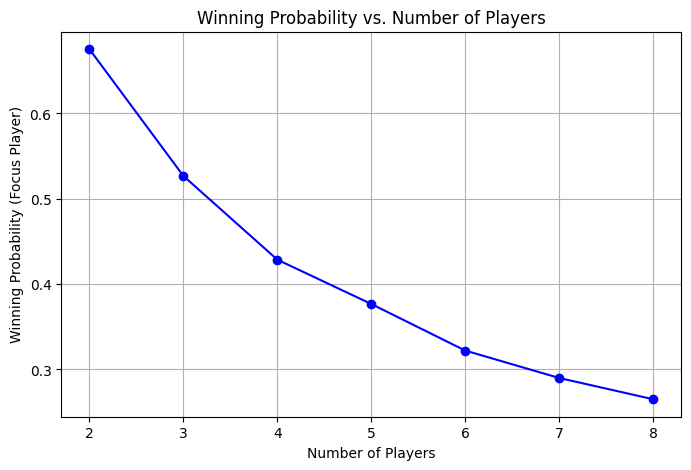

In [16]:
# Visualization: Plot winning probability vs. number of players

import matplotlib.pyplot as plt

# Parameters
n_games = 10000  # number of simulated games
player_range = range(2, 9)  # from 2 to 8 players
focus_player = 0  # index of the player we observe

# Store results
win_rates = []

# Simulate for each number of players
for n_players in player_range:
    df = simulate_wins(n_games=n_games, players=n_players, focus_player=focus_player)
    total_focus_wins = df['Wins'].sum()
    win_rate = total_focus_wins / n_games
    win_rates.append(win_rate)


# Plot
plt.figure(figsize=(8, 5))
plt.plot(player_range, win_rates, marker='o', linestyle='-', color='blue')
plt.title("Winning Probability vs. Number of Players")
plt.xlabel("Number of Players")
plt.ylabel("Winning Probability (Focus Player)")
plt.grid(True)
plt.show()